In [1]:
# Ejecutar esta celda para autorizar el acceso a las unidades compartidas de Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [17]:
import numpy as np
import datetime as dt
from scipy.spatial import KDTree
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
# Read file
import netCDF4
#filename = '/content/drive/Shareddrives/ia-ges-bloom-cm/Modelado/EEMS/Washington-1m-2008-09_compr.nc'
#filename = '/content/drive/Shareddrives/ia-ges-bloom-cm/IoT/Washington-1d-2008-09-12_compr.nc'
#filename='/content/drive/Shareddrives/ia-ges-bloom-cm/Modelado/EEMS/Washington-1m-2008-09_UGRID.nc'
filename='..\dataedge\Washington-1m-2008-09_UGRID.nc'

# Read file
nc = netCDF4.Dataset(filename)
# File info
print(nc) # General attributes
print(nc.dimensions)
print(nc.variables.keys()) # All variables names
#print(nc.variables) # All variables and their attributes

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.4
    Project: EFDC_
    utm_zone: UTM Zone  10 Northern Hemisphere
    dimensions(sizes): TIME(721), NODE(1448), CELL(1183), FOUR(4), LCM(1185), IC(62), JC(78), KC(55), KB(0), NDYE(1), NTOX(0), NSED(0), NSND(0), NSXD(0), NALG(2), NZOO(0), NSHF(0), NQCTL(0), NQWR(0), NPD(0)
    variables(dimensions): uint32 mesh(), uint32 nv(CELL, FOUR), float32 lon(NODE), float32 lat(NODE), float32 lonc(CELL), float32 latc(CELL), int8 layers(CELL), int8 bottom_layer(CELL), float32 sigma(CELL, KC), float32 layer_thickness(CELL, KC), float32 CUV(CELL, FOUR), float32 RSSBC(LCM, FOUR), float32 SEDDIA(NSXD), float64 time(TIME), float32 BELV(TIME, CELL), float32 HP(TIME, CELL), float32 WSEL(TIME, CELL), float32 U(TIME, KC, CELL), float32 V(TIME, KC, CELL), float32 W(TIME, KC, CELL), float32 DELT(TIME), float32 total_shear(TIME, CELL), float32 temperature(TIME, KC, CELL), float32 RPOC(TIME, KC, CELL), 

In [19]:
# Read variables
#   Not all variables have the same dimensions, see file info for details
latc = np.array(nc['latc'])     # float32 latc(CELL)
lonc = np.array(nc['lonc'])     # float32 lonc(CELL)
time=np.array(nc['time'])       # float64 time(TIME), Dias desde 20050101
sigma=np.array(nc['sigma'])     # float32 sigma(CELL, KC)
belv = np.array(nc['BELV'])[0]  # float32 BELV(TIME, CELL), 
wsel =np.array(nc['WSEL'])      # float32 WSEL(TIME, CELL) 

temp=np.array(nc['temperature'])   #float32 temperature(TIME, KC, CELL)
alg = np.array(nc['ALG'])       # float32 ALG(TIME, NALG, KC, CELL), 2 Algas
wind_x=np.array(nc['wind_x'])   # float32 wind_x(TIME, CELL), Velocidad viento este (m/s)
wind_y=np.array(nc['wind_y'])   # float32 wind_y(TIME, CELL), Velocidad viento norte (m/s)
nox=np.array(nc['NOX'])         # Nitratos (mg/L)
dox=np.array(nc['DOX'])         # Oxigeno disuelto (mg/L)
u=np.array(nc['U'])             # Velocidad del agua este(m/s)
v=np.array(nc['V'])             # Velocidad del agua norte(m/s)
w=np.array(nc['W'])             # Velocidad del agua arriba(m/s)
# float32 DON(TIME, KC, CELL),
# float32 NHX(TIME, KC, CELL),
# float32 SUU(TIME, KC, CELL),
# float32 SAA(TIME, KC, CELL),
# float32 COD(TIME, KC, CELL),

# temp[temp < -10] = np.nan
# belv[belv < -500] = np.nan
# wsel[wsel < -500] = np.nan
# sigma[sigma > 1] = np.nan
# sigma[sigma < 0] = np.nan
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(lonc,latc,c=belv ,s=5, cmap=plt.cm.jet)
cbar = plt.colorbar()
plt.xlabel('Longitude'), plt.xticks(rotation=30)
plt.ylabel('Latitude')
cbar.set_label('Bottom elevation')
plt.title('Geographic coordinates')
plt.gca().set_aspect('equal')
plt.show()

In [24]:
#Process variables
llc=np.c_[lonc.ravel(), latc.ravel()]
lonlattree = KDTree(llc) 

refstr=nc['time'].units
refdate=dt.datetime.fromisoformat(refstr[-19:])
dtini=refdate+dt.timedelta(seconds=time[0]*24*3600)
dtend=refdate+dt.timedelta(seconds=time[-1]*24*3600)
print('BodySim IniDateTime:',dtini)
print('BodySim EndDateTime:',dtend)
mytime=(time-time[0])*24*3600      #Time in seconds from 0.  

deltat=dt.day(1)
dt=dtini+time*deltat
hours=dt.hour(dt)
sun=max(np.cos((hours+12)/24*2*np.pi),0) #Genero el Sol

# Remove fill values
#   The cells in which no water is present are filled with FillValue
#   Change FillValue to NaN so that those cells don't appear in the plot
#var[var == nc[varname].FillValue] = np.nan
#latc[latc == nc['latc'].FillValue] = np.nan
#lonc[lonc == nc['lonc'].FillValue] = np.nan
#WQ_O[WQ_O== nc['WQ_O'].FillValue]=np.nan


#inidt=dt.datetime(ncinfo.Variables(14).Attributes(3).Value(end-18:end))
# deltat=dt.days(1)
# dt=inidt+time*deltat
# hours=hour(dt);
# sun=max(cos((hours+12)/24*2*pi),0); %Genero el Sol





BodySim IniDateTime: 2008-08-23 00:00:00
BodySim EndDateTime: 2008-09-07 00:00:00


AttributeError: module 'datetime' has no attribute 'day'

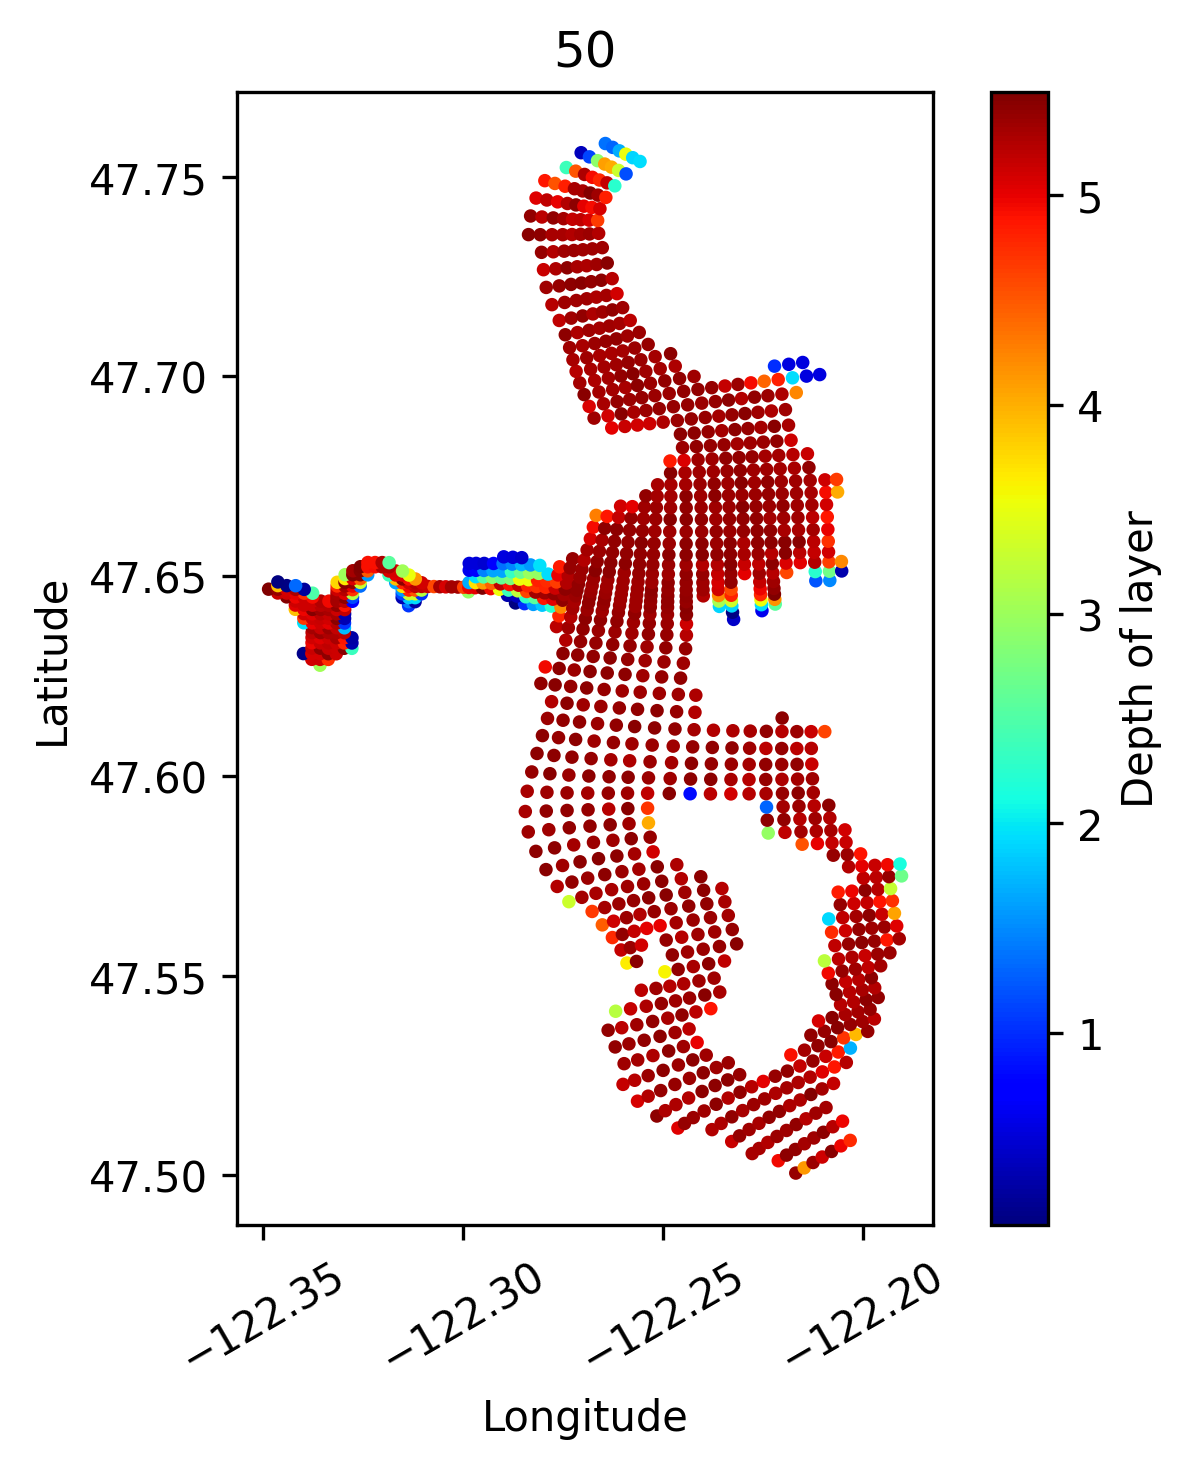

In [4]:
# Get z and depth
l=50
t=0
wsel0=wsel[t,:]

z = belv + sigma[:,l]*(wsel0 - belv)
depth = wsel0 - z

plt.close()
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(lonc,latc,c=depth ,s=5, cmap=plt.cm.jet)
cbar = plt.colorbar()
plt.xlabel('Longitude'), plt.xticks(rotation=30)
plt.ylabel('Latitude')
cbar.set_label('Depth of layer')
plt.title(l)
plt.gca().set_aspect('equal')
plt.show()







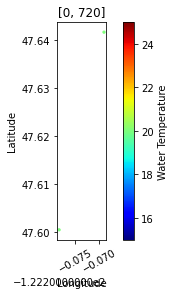

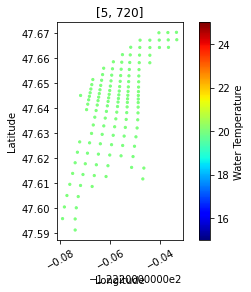

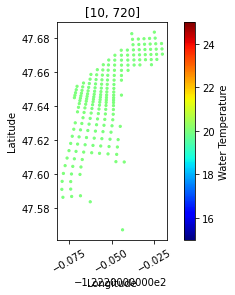

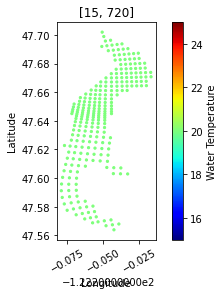

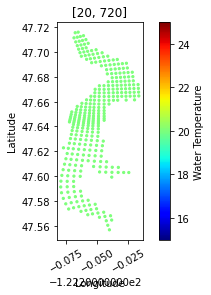

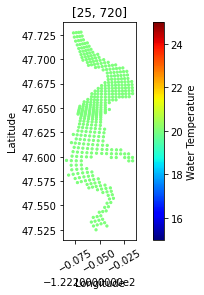

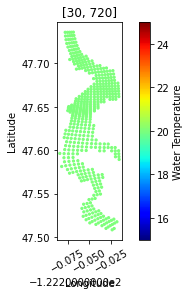

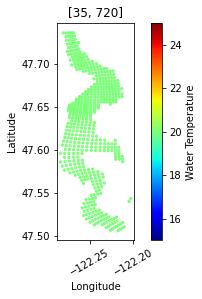

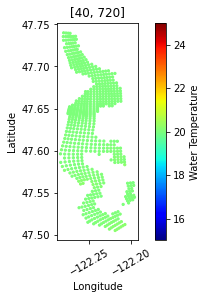

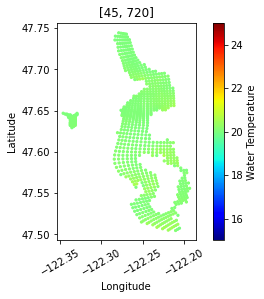

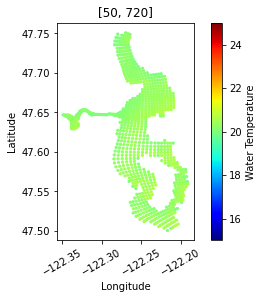

In [5]:



# Flatten arrays and remove NaNs
#varflat = var[np.logical_not(np.isnan(var))]
#latflat = lat[np.logical_not(np.isnan(var))]
#lonflat = lon[np.logical_not(np.isnan(var))]

# Geographic coordinates plot
#   Actual data points in geographic coordinates (lon, lat)
#   Placed at the center of the simulated cells

vmin=15 #temp[t,l,:].min()
vmax=25 #temp[t,l,:].max() #25.0 #np.nanmax(var[:,1,:,:])
nalg=1

fig=plt.figure(figsize=(2.0, 2.0), dpi=200)
plt.close()
for l in range(0,55,5): # in range(4,55,10):
  for t in range(720,721):
    plt.scatter(lonc,latc,c=temp[t,l,:] ,s=5, cmap=plt.cm.jet,vmin=vmin, vmax=vmax)
    cbar = plt.colorbar()
    #cbar.set_clim( vmin=0, vmax=1)
    plt.xlabel('Longitude'), plt.xticks(rotation=30)
    plt.ylabel('Latitude')
    cbar.set_label('Water Temperature')
    plt.title([l,t])
    plt.gca().set_aspect('equal')
    plt.show()



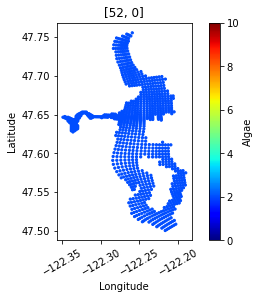

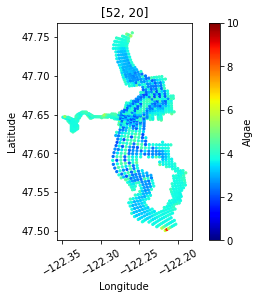

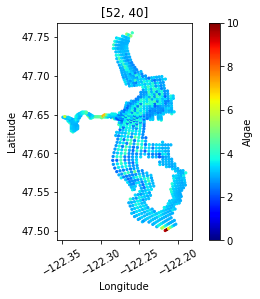

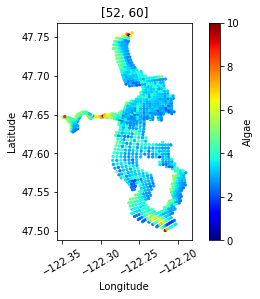

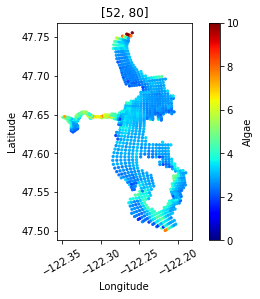

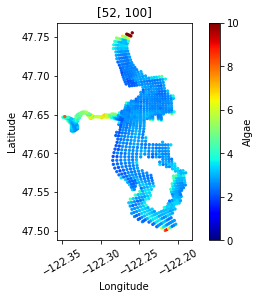

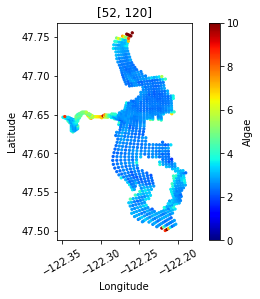

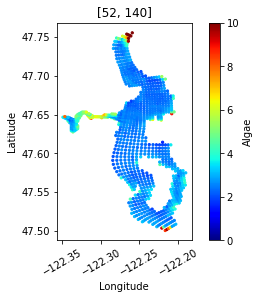

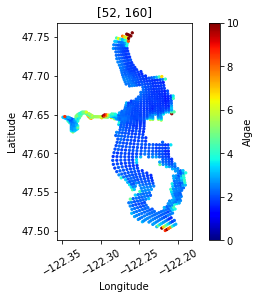

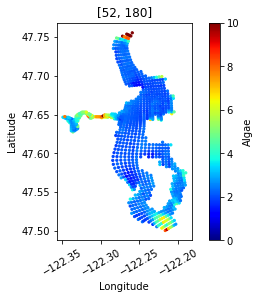

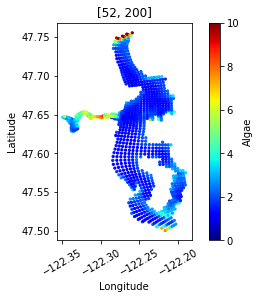

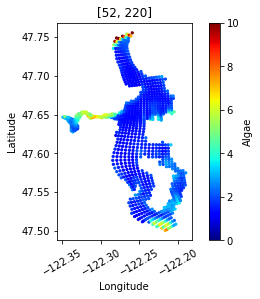

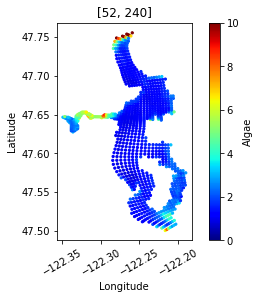

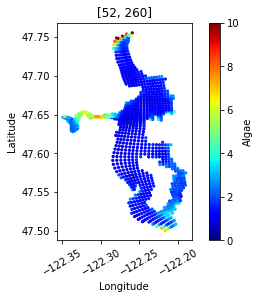

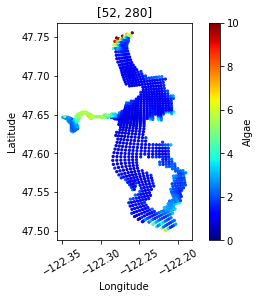

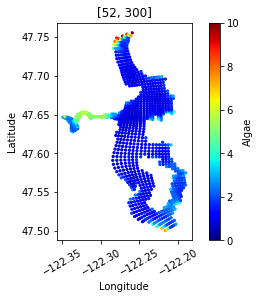

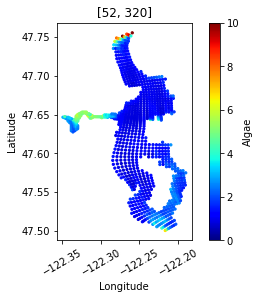

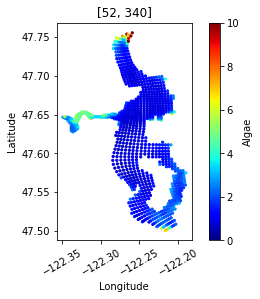

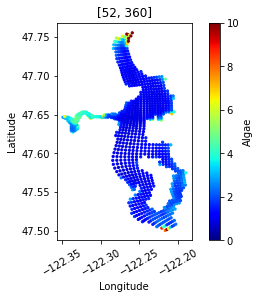

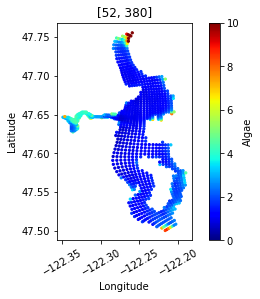

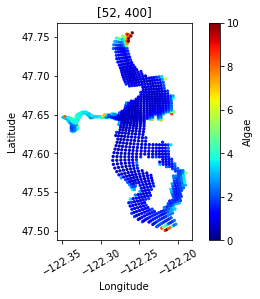

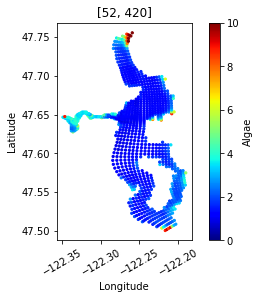

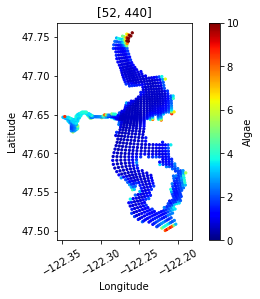

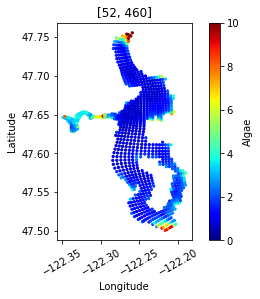

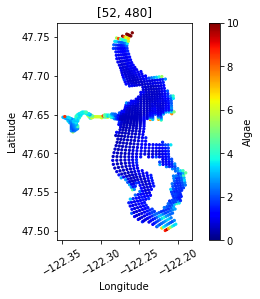

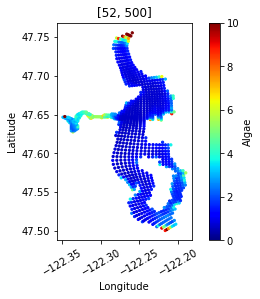

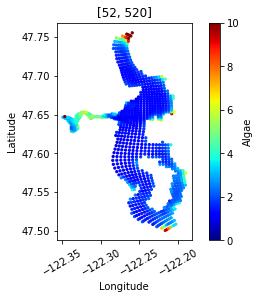

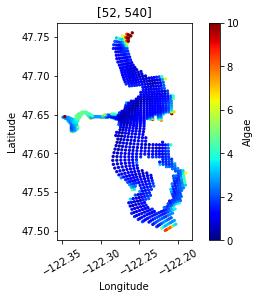

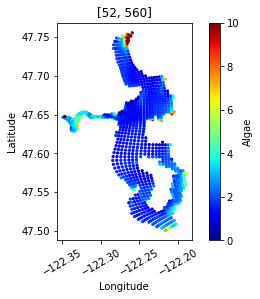

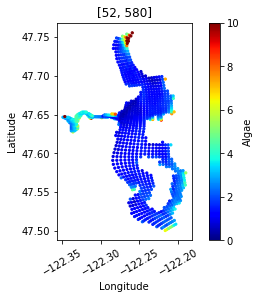

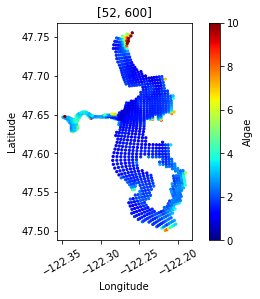

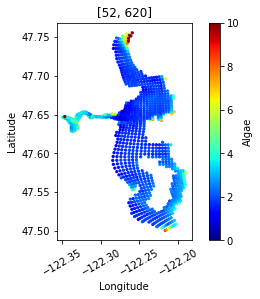

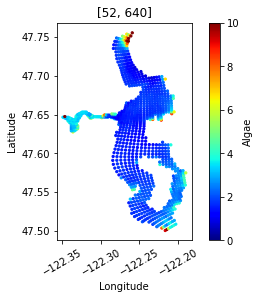

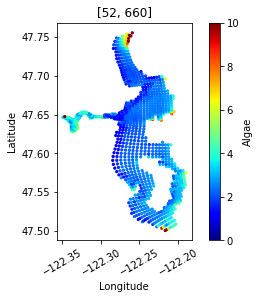

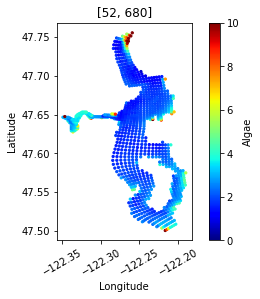

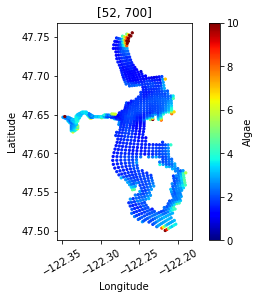

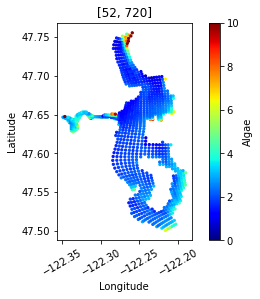

In [6]:
varname='ALG'
var=np.array(nc[varname])
var[var < -500] = np.nan

vmin=0.0
vmax=10 #25.0 #np.nanmax(var[:,1,:,:])


fig=plt.figure(figsize=(2.0, 2.0), dpi=200)
plt.close()
for l in range(52,53,1): # in range(4,55,10):
  for t in range(0,721,20):
    plt.scatter(lonc,latc,c=var[t,nalg,l,:] ,s=5, cmap=plt.cm.jet,vmin=vmin, vmax=vmax)
    cbar = plt.colorbar()
    #cbar.set_clim( vmin=0, vmax=1)
    plt.xlabel('Longitude'), plt.xticks(rotation=30)
    plt.ylabel('Latitude')
    cbar.set_label('Algae')
    plt.title([l,t])
    plt.gca().set_aspect('equal')
    plt.show()



In [7]:
# Interpolate given data to grid
#   Other interpolations might be better for a specific application
x = np.linspace(np.nanmin(lonc), np.nanmax(lonc), 100)
y = np.linspace(np.nanmin(latc), np.nanmax(latc), 100)
z = griddata((lonc, latc), var, (x[None,:], y[:,None]), method='nearest')

# Plot interpolation
#   Example interpolation to approximate in-between points
#   Values outside of the water would be wrong
plt.figure(figsize=(5, 5), dpi=300)
plt.contourf(x,y,z,255,cmap=plt.cm.jet)
cbar = plt.colorbar()
plt.xlabel('Longitude'), plt.xticks(rotation=30)
plt.ylabel('Latitude')
cbar.set_label('Bottom elevation')
plt.title('Interpolation in geographic coordinates')
plt.gca().set_aspect('equal')

ValueError: different number of values and points